# **INTRODUCTION**

## Is There a Need for AI for Digitalized, Accelerated Materials Research?

The recent, fast-growing leverage of AI and machine learning architectures for materials research and development helps to minimize trial and error methods associated with experimental/laboratory work, while also presenting an opportunity to by-pass the computational-intensive work associated with simulation techniques like DFTs, and MDs.

## Using PLMs Over Other NNs and Classical Models?

Building models for prediction using pretrained large language models presents opportunities like having to deal with easily human-readable/understandable data texts; and the boycott of time and energy-consuming data feature engineering processes associated with structured data.

## **Breakdown/Understanding of Task**

This is a text-containing dataset with two colums, one of which a material, it's features, and a certain selected property measurement was described, while the other contains the group of the selected property. For example, the description of strength measurment of an alloy system in column one and "mechanical property" in column two.

The task is to build a model that is able to predict the group of material property based on readable text description of the material and the property measurement.

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check Device

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'using {device} device')

using cuda device


## Data Preprocessing

Simple removal of certain unwanted characters within the dataset

In [3]:
import pandas as pd

file_path = "drive/MyDrive/MPIE_task/matsci_text_classification_dataset.csv"

# Load the dataset
material_text = pd.read_csv(file_path,
                            delimiter = ";",
                            usecols=[0, 1],
                            names = ["feature_description", "property_classification"],
                            skiprows=1)

# Clean the property description column to remove unnecessary characters (commas)
material_text["property_classification"] = material_text["property_classification"].str.replace(",", " ", regex = True).str.strip()

# Drop rows where the property description column is missing (NaN) values
material_text = material_text.dropna(subset=["property_classification"])

#Preview the preprocessed dataset
material_text.head(5)

,feature_description,property_classification
0,The material Ba<sub>4</sub>Ni<sub>1.75</sub>Ge...,electronic and electrical properties
2,The material ErNi<sub>2</sub>B<sub>2</sub>C rt...,magnetic properties
3,The material Ce<sub>3</sub>Te<sub>4</sub> belo...,magnetic properties
4,The material Ca<sub>0.92</sub>Ce<sub>0.08</sub...,superconductivity
5,The material Nb<sub>3</sub>Ge belongs to the G...,superconductivity


In [4]:
pip install transformers

## **Choice of Model: RoBERTa PLM**

The RoBERTa is an improved model of the BERT that generates contextual token embedding, without having to worry about next sentence prediciton. This could be really useful for scientific applications where technical words are very paramont.

## Load Dataset into PLM RoBERTa for Tokenization and Embedding Generation

In [5]:
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel
import torch
import numpy as np
import pandas as pd


# Load the pre-trained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")


#Let's create function for batch proprocessing of data
class MaterialPropertyDataset(Dataset):
    def __init__(self, material_features):
        self.material_features = material_features

    def __len__(self):
        return len(self.material_features)

    def __getitem__(self, idx):
        return self.material_features[idx]

# Create function to generate embeddings in batches
def get_cls_embeddings_batchwise(material_features_list, batch_size = 16):
  # The CLS embeddings have been given priority because it is known to encapsulate the entire sentence rather each generated token which could be arbitraty and strictly model-determined
    dataset = MaterialPropertyDataset(material_features_list)
    dataloader = DataLoader(dataset, batch_size = batch_size)

    all_cls_embeddings = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            tokens = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
            tokens = {key: value.to(device) for key, value in tokens.items()}  # Move tokens to GPU
            output = model(**tokens)
            embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token embedding
            all_cls_embeddings.append(embeddings)

    return np.vstack(all_cls_embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Generate Embeddings from Appropriate Classes and Functions

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Assign the appropriate column of the dataset
material_features_list = material_text["feature_description"].astype(str).tolist()

#Pass in the features text description in batches
cls_embeddings_array = get_cls_embeddings_batchwise(material_features_list, batch_size = 16)

## Visualization of Embeddings Based on Material Class

This is an important part of the task. The material classes (e.g metal, semiconductor) are contained within the feature description column. It would be interesting to see if a plot of the embeddings generated by the model is able to show distinction of the different classes of material. This would already give an insight into its predictive performance.


Possible Material Class Type
intermediate       20
baal4              20
ferroelectric      19
perovskite         19
alb2               19
ionic              19
nonmetal           19
b.c.c.             19
semiconductor      18
ferromagnet        18
close-packed       18
heavy-fermion      18
metal              17
antiferromagnet    17
superconductor     17
cuprate            17
ferrimagnet        16
hard               16
diamagnetic        15
Name: count, dtype: int64


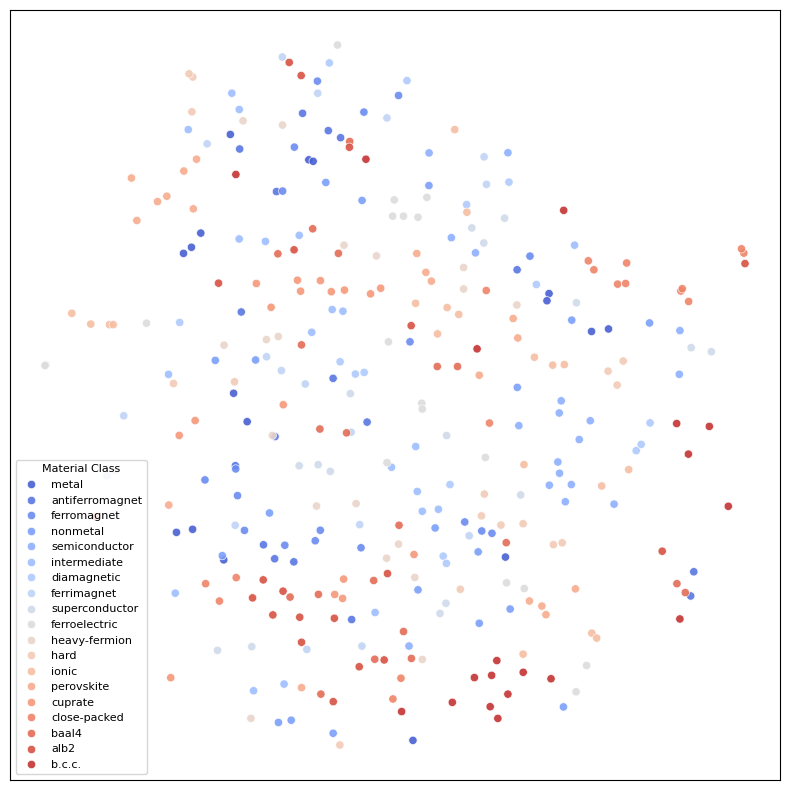

In [9]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

def cls_embeddings_based_on_material_class(cls_embeddings_array, material_text):

    texts = material_text["feature_description"].values



    def get_material_class(text):
      # Convert HTML subscripts (e.g., BaAl<sub>4</sub> to BaAl4)
      text = BeautifulSoup(text, "html.parser").get_text()


      material_classes = {"metal", "antiferromagnet", "ferromagnet","nonmetal",
                          "semiconductor", "intermediate", "diamagnetic",
                          "ferrimagnet", "superconductor", "ferroelectric",
                          "heavy-fermion", "hard", "ionic", "perovskite",
                            "cuprate", "close-packed", "baal4",
                            "alb2", "b.c.c."}


      pattern = r"\b(metal|antiferromagnet|ferromagnet|nonmetal|semiconductor|intermediate|diamagnetic|ferrimagnet|superconductor|ferroelectric|heavy-fermion|hard|ionic|perovskite|cuprate|close-packed|baal4|alb2|b\.c\.c\.)\b"

      match = re.search(pattern, text.lower())

      if match:
        return match.group(1)

      classes = text.lower().split()
      for word in classes:
        if word in material_classes:
          return word

      return "unknown"


    material_classes = [get_material_class(text) for text in texts]


    tsne = TSNE(n_components=2,
                perplexity = min(len(cls_embeddings_array) // 3, 30),
                random_state=42, verbose = 0)
    tsne_results = tsne.fit_transform(cls_embeddings_array)


    embeddings_plot_for_material_class = pd.DataFrame({
        'tsne_1': tsne_results[:, 0], 'tsne_2': tsne_results[:, 1],
        'material_class': material_classes})


    plt.figure(figsize=(8, 8))


    Number_of_material_class = pd.Series(material_classes).value_counts()
    print("\nPossible Material Class Type")
    print(Number_of_material_class)

    sns.scatterplot(data = embeddings_plot_for_material_class,
                           x = 'tsne_1', y = 'tsne_2', hue = 'material_class',
                           palette = "coolwarm", alpha = 0.9)


    plt.legend(title = 'Material Class', loc = 'best', fontsize = 8,
               title_fontsize = 8)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

    return plt, Number_of_material_class

Number_of_material_class = cls_embeddings_based_on_material_class(cls_embeddings_array, material_text)


We observe that the model truly identifies similarities in material classes and shows distinction amongst them. We also observe closeness/overlapping of some material classes which exaplains similarities in their embeddings most likely due to similarities in features and routine for material property measurement description.

## Integrating a Predictive Classification Model for Property Prediction

Based on the nature of our dataset (particularly our label/target property), a multi-categorical classication model is required to predict our material property group. The random forest and support vector classifiers are considered.

Classifications are made with generated CLS embeddings as features.

### Random Forest Classifier

In [17]:
cls_embeddings_array.shape

(341, 768)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


embeddings_for_classification = pd.DataFrame(cls_embeddings_array,
                                             columns = [f"dim_{i}" for i in range(cls_embeddings_array.shape[1])])

predicted_property = material_text["property_classification"]


# Encode the categorical target labels
label_encoder = LabelEncoder()
encoded_property = label_encoder.fit_transform(predicted_property)

# Identify class counts
encoded_property_counts = pd.Series(encoded_property).value_counts()

# Remove rare classes with fewer than 3 samples
valid_properties = encoded_property_counts[encoded_property_counts > 1].index
valid_encoded_property = np.where(np.isin(encoded_property, valid_properties))[0]

# Filter dataset to include only valid classes
embeddings_for_classification = embeddings_for_classification.iloc[valid_encoded_property].reset_index(drop=True)
encoded_property = encoded_property[valid_encoded_property]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_for_classification, encoded_property, test_size = 0.2, random_state = 101)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state = 101)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate model performance
property_prediction_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {property_prediction_accuracy:.4f}")

# Extract all classifiable material property
possible_properties = np.unique(y_test)
possible_property = [label_encoder.classes_[i] for i in possible_properties]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels = possible_properties, target_names = possible_property))

✅ Model Accuracy: 0.5690

Classification Report:
                                      precision    recall  f1-score   support

electronic and electrical properties       0.47      0.69      0.56        13
                 magnetic properties       0.59      0.87      0.70        23
               mechanical properties       0.00      0.00      0.00         3
             metamagnetic transition       0.00      0.00      0.00         1
                  optical properties       0.00      0.00      0.00         1
                   phase transitions       1.00      0.25      0.40         4
                   superconductivity       0.00      0.00      0.00         4
thermal and thermodynamic properties       0.75      0.33      0.46         9

                            accuracy                           0.57        58
                           macro avg       0.35      0.27      0.27        58
                        weighted avg       0.52      0.57      0.50        58



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Support Vector Classifier

In [20]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

embeddings_for_classification = pd.DataFrame(cls_embeddings_array,
                                             columns = [f"dim_{i}" for i in range(cls_embeddings_array.shape[1])])

predicted_property = material_text["property_classification"]


# Encode the categorical target labels
label_encoder = LabelEncoder()
encoded_property = label_encoder.fit_transform(predicted_property)

# Identify class counts
encoded_property_counts = pd.Series(encoded_property).value_counts()

# Remove rare classes with fewer than 3 samples
valid_properties = encoded_property_counts[encoded_property_counts > 1].index
valid_encoded_property = np.where(np.isin(encoded_property, valid_properties))[0]

# Filter dataset to include only valid classes
embeddings_for_classification = embeddings_for_classification.iloc[valid_encoded_property].reset_index(drop=True)
encoded_property = encoded_property[valid_encoded_property]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_for_classification, encoded_property, test_size = 0.2, random_state = 101)

 #Standardize the data (SVM requires scaled features for better performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM Classifier
svm_clf = SVC(kernel = "linear", probability = True, random_state = 101)
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test)

# Evaluate model performance
property_prediction_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {property_prediction_accuracy:.4f}")

# Extract all classifiable material property
possible_properties = np.unique(y_test)
possible_property = [label_encoder.classes_[i] for i in possible_properties]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels = possible_properties, target_names = possible_property))

✅ Model Accuracy: 0.7241

Classification Report:
                                      precision    recall  f1-score   support

electronic and electrical properties       0.58      0.85      0.69        13
                 magnetic properties       0.82      0.78      0.80        23
               mechanical properties       0.00      0.00      0.00         3
             metamagnetic transition       0.00      0.00      0.00         1
                  optical properties       0.00      0.00      0.00         1
                   phase transitions       1.00      1.00      1.00         4
                   superconductivity       0.67      0.50      0.57         4
thermal and thermodynamic properties       0.78      0.78      0.78         9

                            accuracy                           0.72        58
                           macro avg       0.48      0.49      0.48        58
                        weighted avg       0.69      0.72      0.70        58



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With accuracy, as a measurement metric, the support vector classifier shows to have the better predictive performance of the two multi-categorical classification models assessed.

#### **Would MatBERT perform better??**

MatBERT is an extension of BERT just like RoBERTa, but that have been trained on particularly on materials science realated terms, parameters, and dataset. It would be interesting to see how tokenization is done using this domain-specific PLMs and see if embeddings generated differ from those of RoBERTa designed to address generic NLP tasks.

Installing/Downloading MatBERT

In [21]:
# Set the model storage path inside Google Drive
MODEL_PATH="/content/drive/MyDrive/matbert"
!mkdir -p "$MODEL_PATH/matbert-base-cased"
!mkdir -p "$MODEL_PATH/matbert-base-uncased"

# Download MatBERT (Cased Version)
!wget -O "$MODEL_PATH/matbert-base-cased/config.json" https://cedergroup-share.s3-us-west-2.amazonaws.com/public/MatBERT/model_2Mpapers_cased_30522_wd/config.json
!wget -O "$MODEL_PATH/matbert-base-cased/vocab.txt" https://cedergroup-share.s3-us-west-2.amazonaws.com/public/MatBERT/model_2Mpapers_cased_30522_wd/vocab.txt
!wget -O "$MODEL_PATH/matbert-base-cased/pytorch_model.bin" https://cedergroup-share.s3-us-west-2.amazonaws.com/public/MatBERT/model_2Mpapers_cased_30522_wd/pytorch_model.bin

# Download MatBERT (Uncased Version)
!wget -O "$MODEL_PATH/matbert-base-uncased/config.json" https://cedergroup-share.s3-us-west-2.amazonaws.com/public/MatBERT/model_2Mpapers_uncased_30522_wd/config.json
!wget -O "$MODEL_PATH/matbert-base-uncased/vocab.txt" https://cedergroup-share.s3-us-west-2.amazonaws.com/public/MatBERT/model_2Mpapers_uncased_30522_wd/vocab.txt
!wget -O "$MODEL_PATH/matbert-base-uncased/pytorch_model.bin" https://cedergroup-share.s3-us-west-2.amazonaws.com/public/MatBERT/model_2Mpapers_uncased_30522_wd/pytorch_model.bin

--2025-03-17 15:34:21--  https://cedergroup-share.s3-us-west-2.amazonaws.com/public/MatBERT/model_2Mpapers_cased_30522_wd/config.json
Resolving cedergroup-share.s3-us-west-2.amazonaws.com (cedergroup-share.s3-us-west-2.amazonaws.com)... 3.5.76.13, 52.92.145.202, 52.92.229.50, ...
Connecting to cedergroup-share.s3-us-west-2.amazonaws.com (cedergroup-share.s3-us-west-2.amazonaws.com)|3.5.76.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 507 [application/json]
Saving to: ‘/content/drive/MyDrive/matbert/matbert-base-cased/config.json’

/content/drive/MyDr 100%[===================>]     507  --.-KB/s    in 0s      

2025-03-17 15:34:22 (7.27 MB/s) - ‘/content/drive/MyDrive/matbert/matbert-base-cased/config.json’ saved [507/507]

--2025-03-17 15:34:22--  https://cedergroup-share.s3-us-west-2.amazonaws.com/public/MatBERT/model_2Mpapers_cased_30522_wd/vocab.txt
Resolving cedergroup-share.s3-us-west-2.amazonaws.com (cedergroup-share.s3-us-west-2.amazonaws.com)... 3

### Importing MatBERT Tokenizer and Model

In [22]:
from transformers import BertTokenizerFast, BertModel

# Set MatBERT model path (Update if needed)
MODEL_PATH = "/content/drive/MyDrive/matbert/matbert-base-cased"

# Load MatBERT tokenizer
mattokenizer = BertTokenizerFast.from_pretrained(MODEL_PATH, do_lower_case=False)

# Load MatBERT model
matmodel = BertModel.from_pretrained(MODEL_PATH)

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/matbert/matbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Generating Embeddings Using MatBERT Model

In [23]:
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import pandas as pd


#Let's create function for batch proprocessing of data
class MaterialPropertyDataset(Dataset):
    def __init__(self, material_features):
        self.material_features = material_features

    def __len__(self):
        return len(self.material_features)

    def __getitem__(self, idx):
        return self.material_features[idx]

# Create function to generate embeddings in batches
def get_cls_embeddings_batchwise(material_features_list, batch_size = 16):
    dataset = MaterialPropertyDataset(material_features_list)
    dataloader = DataLoader(dataset, batch_size = batch_size)

    all_cls_embeddings_from_mat = []

    matmodel.eval()
    with torch.no_grad():
        for batch in dataloader:
            tokens = mattokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
            tokens = {key: value.to(device) for key, value in tokens.items()}  # Move tokens to GPU
            output = matmodel(**tokens)
            embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token embedding
            all_cls_embeddings_from_mat.append(embeddings)

    return np.vstack(all_cls_embeddings_from_mat)

## Getting the Generated Embeddings from MatBERT

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
matmodel.to(device)


# Assign the appropriate column of the dataset
material_features_list = material_text["feature_description"].astype(str).tolist()

#Pass in the features text description in batches
cls_embeddings_array_from_mat = get_cls_embeddings_batchwise(material_features_list, batch_size = 16)

## Visualization of the Embeddings Generated by MatBERT Based on the Material Class


Possible Material Class Type
intermediate       20
baal4              20
ferroelectric      19
perovskite         19
alb2               19
ionic              19
nonmetal           19
b.c.c.             19
semiconductor      18
ferromagnet        18
close-packed       18
heavy-fermion      18
metal              17
antiferromagnet    17
superconductor     17
cuprate            17
ferrimagnet        16
hard               16
diamagnetic        15
Name: count, dtype: int64


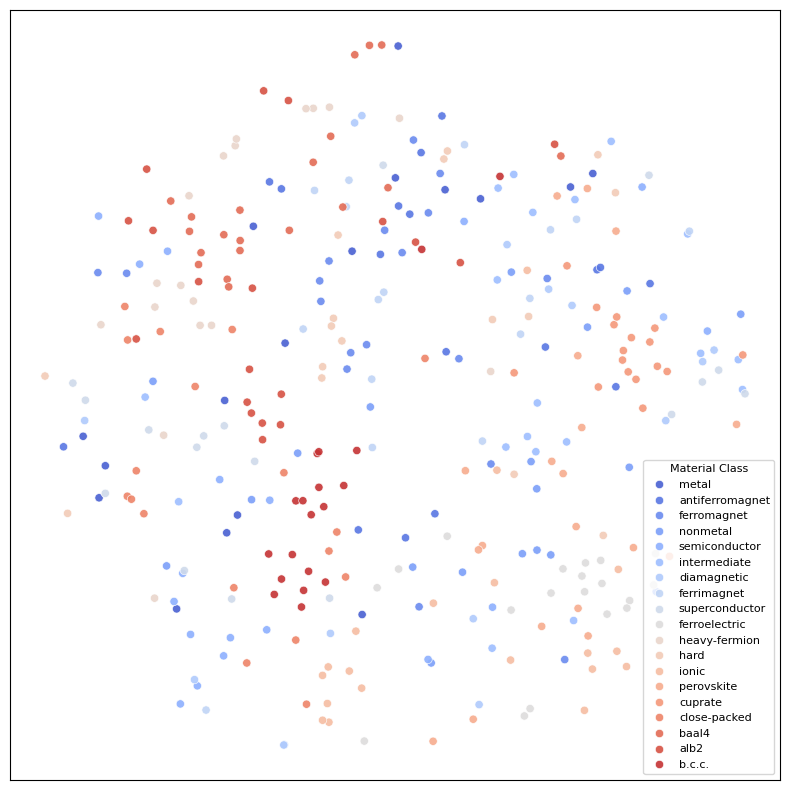

In [25]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

def cls_embeddings_from_mat_based_on_material_class(cls_embeddings_array_from_mat, material_text):

    texts = material_text["feature_description"].values



    def get_material_class(text):
      # Convert HTML subscripts (e.g., BaAl<sub>4</sub> to BaAl4)
      text = BeautifulSoup(text, "html.parser").get_text()


      material_classes = {"metal", "antiferromagnet", "ferromagnet","nonmetal",
                          "semiconductor", "intermediate", "diamagnetic",
                          "ferrimagnet", "superconductor", "ferroelectric",
                          "heavy-fermion", "hard", "ionic", "perovskite",
                            "cuprate", "close-packed", "baal4",
                            "alb2", "b.c.c."}


      pattern = r"\b(metal|antiferromagnet|ferromagnet|nonmetal|semiconductor|intermediate|diamagnetic|ferrimagnet|superconductor|ferroelectric|heavy-fermion|hard|ionic|perovskite|cuprate|close-packed|baal4|alb2|b\.c\.c\.)\b"

      match = re.search(pattern, text.lower())

      if match:
        return match.group(1)

      classes = text.lower().split()
      for word in classes:
        if word in material_classes:
          return word

      return "unknown"


    material_classes = [get_material_class(text) for text in texts]


    tsne = TSNE(n_components=2,
                perplexity = min(len(cls_embeddings_array) // 3, 30),
                random_state=42, verbose = 0)
    tsne_results = tsne.fit_transform(cls_embeddings_array_from_mat)


    embeddings_plot_from_mat_for_material_class = pd.DataFrame({
        'tsne_1': tsne_results[:, 0], 'tsne_2': tsne_results[:, 1],
        'material_class': material_classes})


    plt.figure(figsize=(8, 8))


    Number_of_material_class = pd.Series(material_classes).value_counts()
    print("\nPossible Material Class Type")
    print(Number_of_material_class)

    sns.scatterplot(data = embeddings_plot_from_mat_for_material_class,
                           x = 'tsne_1', y = 'tsne_2', hue = 'material_class',
                           palette = "coolwarm", alpha = 0.9)


    plt.legend(title = 'Material Class', loc = 'best', fontsize = 8,
               title_fontsize = 8)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

    return plt, Number_of_material_class

Number_of_material_class = cls_embeddings_from_mat_based_on_material_class(cls_embeddings_array_from_mat, material_text)

Embeddings generated by MatBERT model, just like in RoBERTa were able to show clustering of embeddings based on the material class - giving insight into distinction amongst these material classes. We probably also observe "better" distinction in the clustering.

## Integrating SVC Classification Model to the MatBERT Generated Embeddings

In [26]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

mat_embeddings_for_classification = pd.DataFrame(cls_embeddings_array_from_mat,
                                             columns = [f"dim_{i}" for i in range(cls_embeddings_array_from_mat.shape[1])])

predicted_property = material_text["property_classification"]


# Encode the categorical target labels
label_encoder = LabelEncoder()
encoded_property = label_encoder.fit_transform(predicted_property)

# Identify class counts
encoded_property_counts = pd.Series(encoded_property).value_counts()

# Remove rare classes with fewer than 3 samples
valid_properties = encoded_property_counts[encoded_property_counts > 1].index
valid_encoded_property = np.where(np.isin(encoded_property, valid_properties))[0]

# Filter dataset to include only valid classes
mat_embeddings_for_classification = mat_embeddings_for_classification.iloc[valid_encoded_property].reset_index(drop=True)
encoded_property = encoded_property[valid_encoded_property]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_for_classification, encoded_property, test_size = 0.2, random_state = 101)

 #Standardize the data (SVM requires scaled features for better performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM Classifier
svm_clf = SVC(kernel = "linear", probability = True, random_state = 101)
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test)

# Evaluate model performance
mat_property_prediction_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {mat_property_prediction_accuracy:.4f}")

# Extract all classifiable material property
possible_properties = np.unique(y_test)
possible_property = [label_encoder.classes_[i] for i in possible_properties]

# Classification Report Generated from Training with MatBERT Embeddings
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels = possible_properties, target_names = possible_property))

✅ Model Accuracy: 0.7241

Classification Report:
                                      precision    recall  f1-score   support

electronic and electrical properties       0.58      0.85      0.69        13
                 magnetic properties       0.82      0.78      0.80        23
               mechanical properties       0.00      0.00      0.00         3
             metamagnetic transition       0.00      0.00      0.00         1
                  optical properties       0.00      0.00      0.00         1
                   phase transitions       1.00      1.00      1.00         4
                   superconductivity       0.67      0.50      0.57         4
thermal and thermodynamic properties       0.78      0.78      0.78         9

                            accuracy                           0.72        58
                           macro avg       0.48      0.49      0.48        58
                        weighted avg       0.69      0.72      0.70        58



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The SVC doesn't however show that the MatBERT model improves the predictive performance of the classifier.

## **Outlook**

I believe the performance of the PLMs and consequently the models can be improved if:

More data are provided to the PLMs to work with. This also presents the classification models with more data to train and test on. More so, with more data, it becomes very reasonable to bag and boost the forest classifier for improved predictive performance.

The models are fine-tuned using self-developed, controlled dataset either from experimentally/simulations generated dataset, or from very reliable database.

I abstractly think it is possible to harness the attentions computed
during the embedding generation process to gain better insights into how the PLMs handle material features and general description, and their overall influence on the group of predicted material property.